# Телеком

### Описание проекта

Оператор связи «.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цели:**

* Создать модель прогнозирования оттока клиентов.
* Найти какие признаки оказывают наибольшее влияние на отток клиентов.

### План решения задачи

1. **EDA**. Обработка аномалий, пропусков и генерация новых фичей на основе имеющихся данных. Составление единого датафрема с индексом customerID.
2. **Моделирование**. Разбиение на тестовую и тренировочную выборку. Выполнить подбор гиперпараметров.
3. **Доводка модели**. Убрать ухудшающие или не влияющие признаки. Выделить самые значимые фичи.

### Описание услуг

**Оператор предоставляет два основных типа услуг:**
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

**Также доступны такие услуги:**

* Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
* Выделенная линия технической поддержки (TechSupport);
* Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
* Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец customerID содержит код клиента.

# Загрузка и подготовка данных

In [1]:
import os
import re
import glob
import pandas as pd
import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score

from catboost import CatBoost, Pool, CatBoostClassifier, cv
from catboost.utils import get_roc_curve, select_threshold

In [2]:
pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

In [3]:
random_state = 38
test_size = 0.2

Загрузим файлы из /datasets/final_steel/ или локального хранилища.

In [4]:
url = './datasets/final_provider/'
files = glob.glob(os.path.join(url, '*.csv'))
files

['./datasets/final_provider\\contract.csv',
 './datasets/final_provider\\internet.csv',
 './datasets/final_provider\\personal.csv',
 './datasets/final_provider\\phone.csv']

In [5]:
contract = pd.read_csv(files[0])
internet = pd.read_csv(files[1])
personal = pd.read_csv(files[2])
phone = pd.read_csv(files[3])

Приведем названия признаков к pythonic way.

In [6]:
def to_underscore(raw_column):
    return '_'.join([
        column.lower() for column in re.split(r'([A-Z]{1,2}[a-z]*)', raw_column) if column
    ])

In [7]:
contract.columns = map(to_underscore, contract.columns)
internet.columns = map(to_underscore, internet.columns)
personal.columns = map(to_underscore, personal.columns)
phone.columns = map(to_underscore, phone.columns)

## Объединение датафреймов и проверка на наличие пропусков и дубликатов в данных

Оценим есть ли пропуски или дубликаты в customer_id у наших датафреймов.

> id уникальны, NaN отсутсвуют.

In [8]:
[x.customer_id.duplicated().sum() for x in [contract, internet, personal, phone]]

[0, 0, 0, 0]

In [9]:
[x.isna().sum().sum() for x in [contract, internet, personal, phone]]

[0, 0, 0, 0]

Теперь объединим данные по customer_id.

In [10]:
for df in [contract, internet, personal, phone]:
    df.set_index('customer_id', inplace=True)
    
df = personal.join([contract, phone, internet], how='left')
df = df.reset_index()

print(df.shape, end='\n\n')
with pd.option_context('display.max_columns', None):
    display(df.head())

(7043, 20)



,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850,29.85,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.950,1889.5,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.850,108.15,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.300,1840.75,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.700,151.65,No,Fiber optic,No,No,No,No,No,No


# Исследовательский анализ данных | Feature engineering

Определим целевую переменную churn.

Как мы видим выборка не сбалансированная, при этом отток клиентов достаточно большой.

In [11]:
df['churn'] = ~(df.end_date == 'No') *1
df.churn.value_counts()

0    5174
1    1869
Name: churn, dtype: int64

Приведем begin_date и end_date к типу datetime.

In [12]:
df.end_date = df.end_date.where(df.end_date != 'No')

df.begin_date = pd.to_datetime(df.begin_date)
df.end_date = pd.to_datetime(df.end_date)

По распределению видно, что в 2019-2020 гг. стало резко расти число новых клиентов, и в тоже время начался отток.

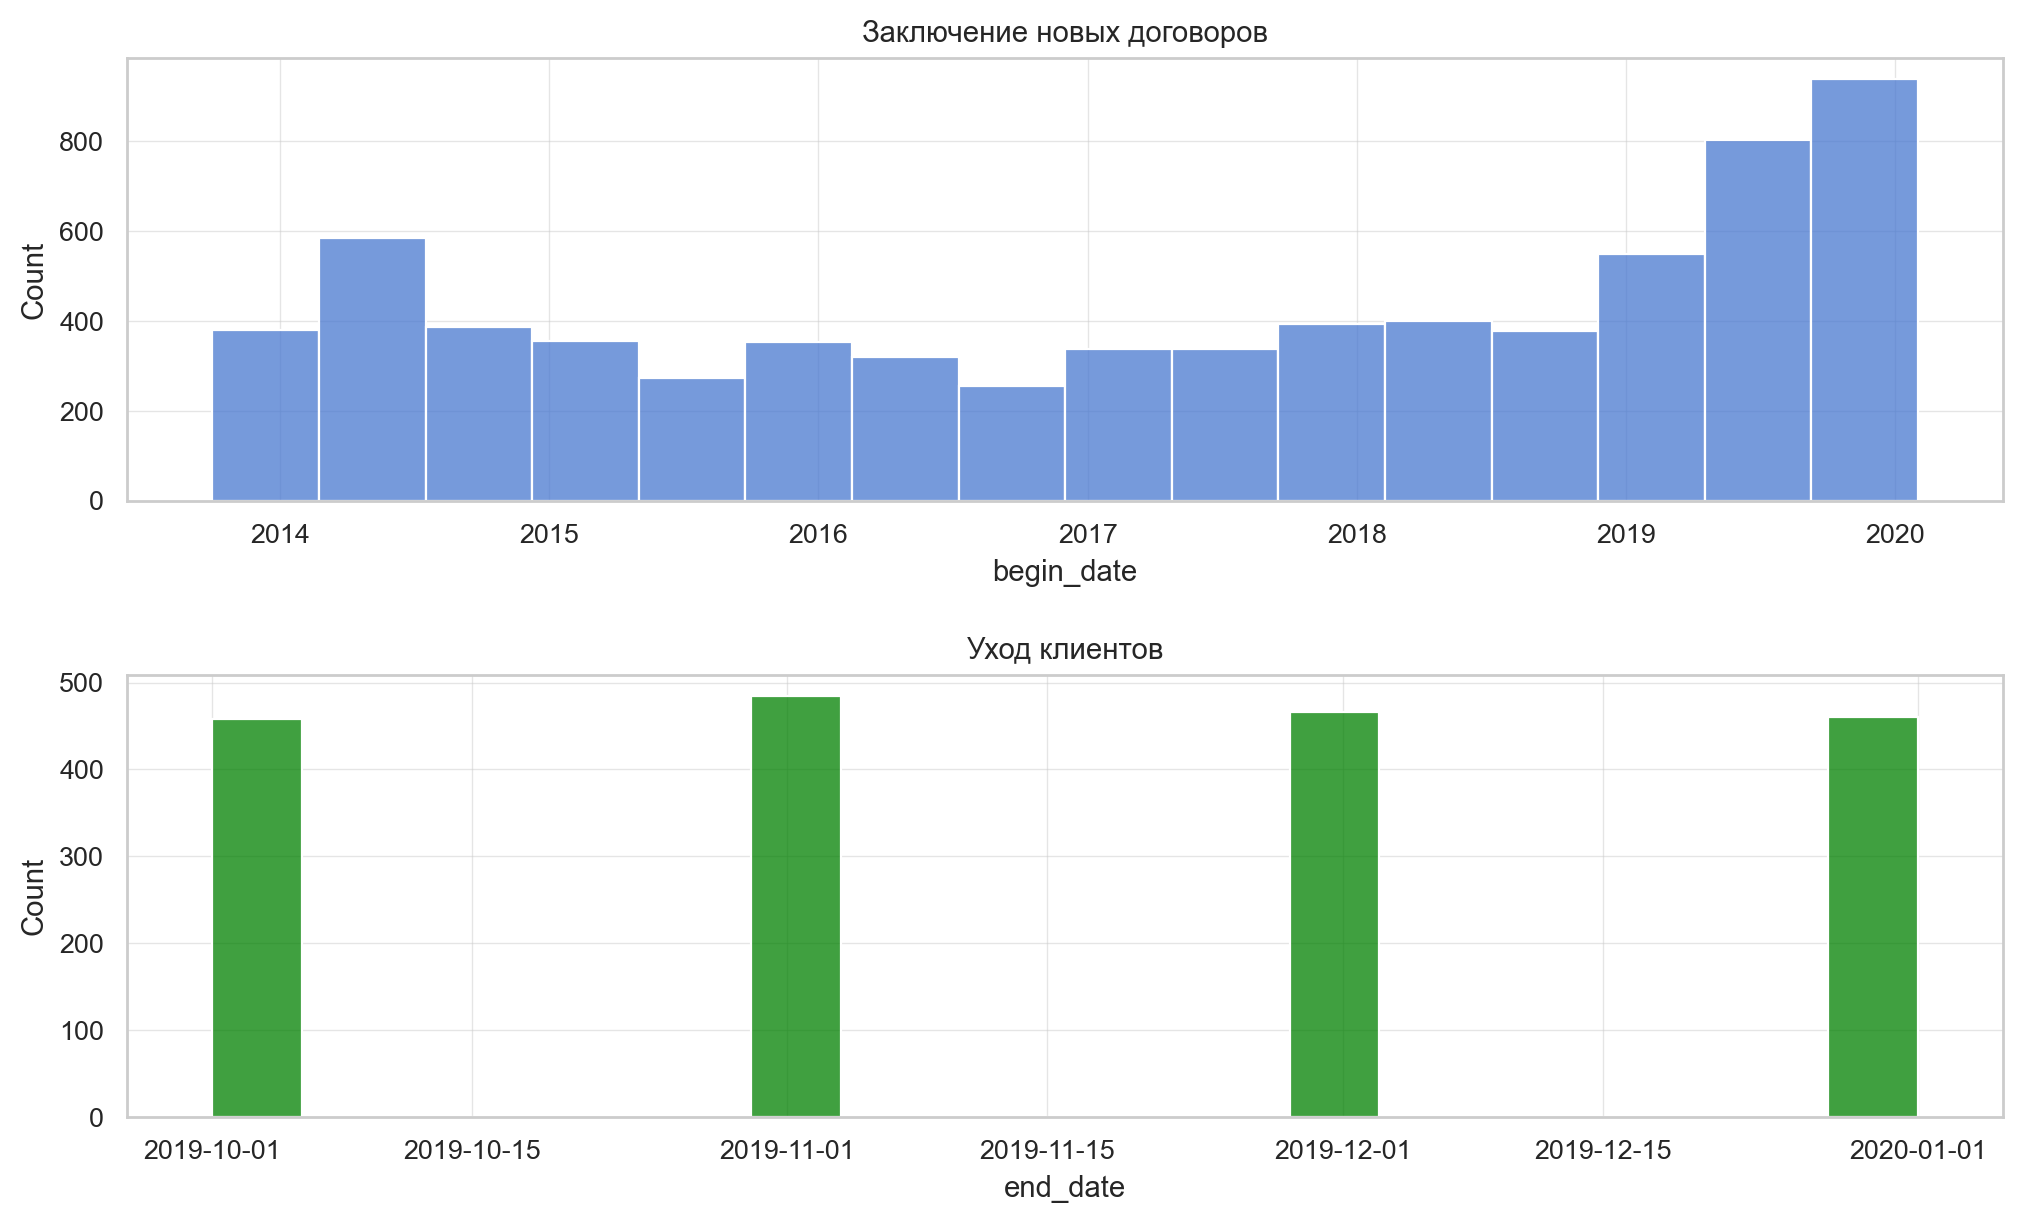

In [13]:
fig, axes = plt.subplots(2, 1)
sns.histplot(data=df, x='begin_date', ax=axes[0])
sns.histplot(data=df, x='end_date', color='green', ax=axes[1])

axes[0].set_title('Заключение новых договоров')
axes[1].set_title('\nУход клиентов')

plt.show()

Так как даты выгрузки у нас нет, то заполним end_date максимумом, чтобы затем посчитать сколько времени клиент является пользователем услуг.

In [14]:
df.end_date.fillna(max(df.begin_date.max(), df.end_date.max()),
                   inplace=True)

In [15]:
df['lifetime'] = (df.end_date - df.begin_date).dt.days

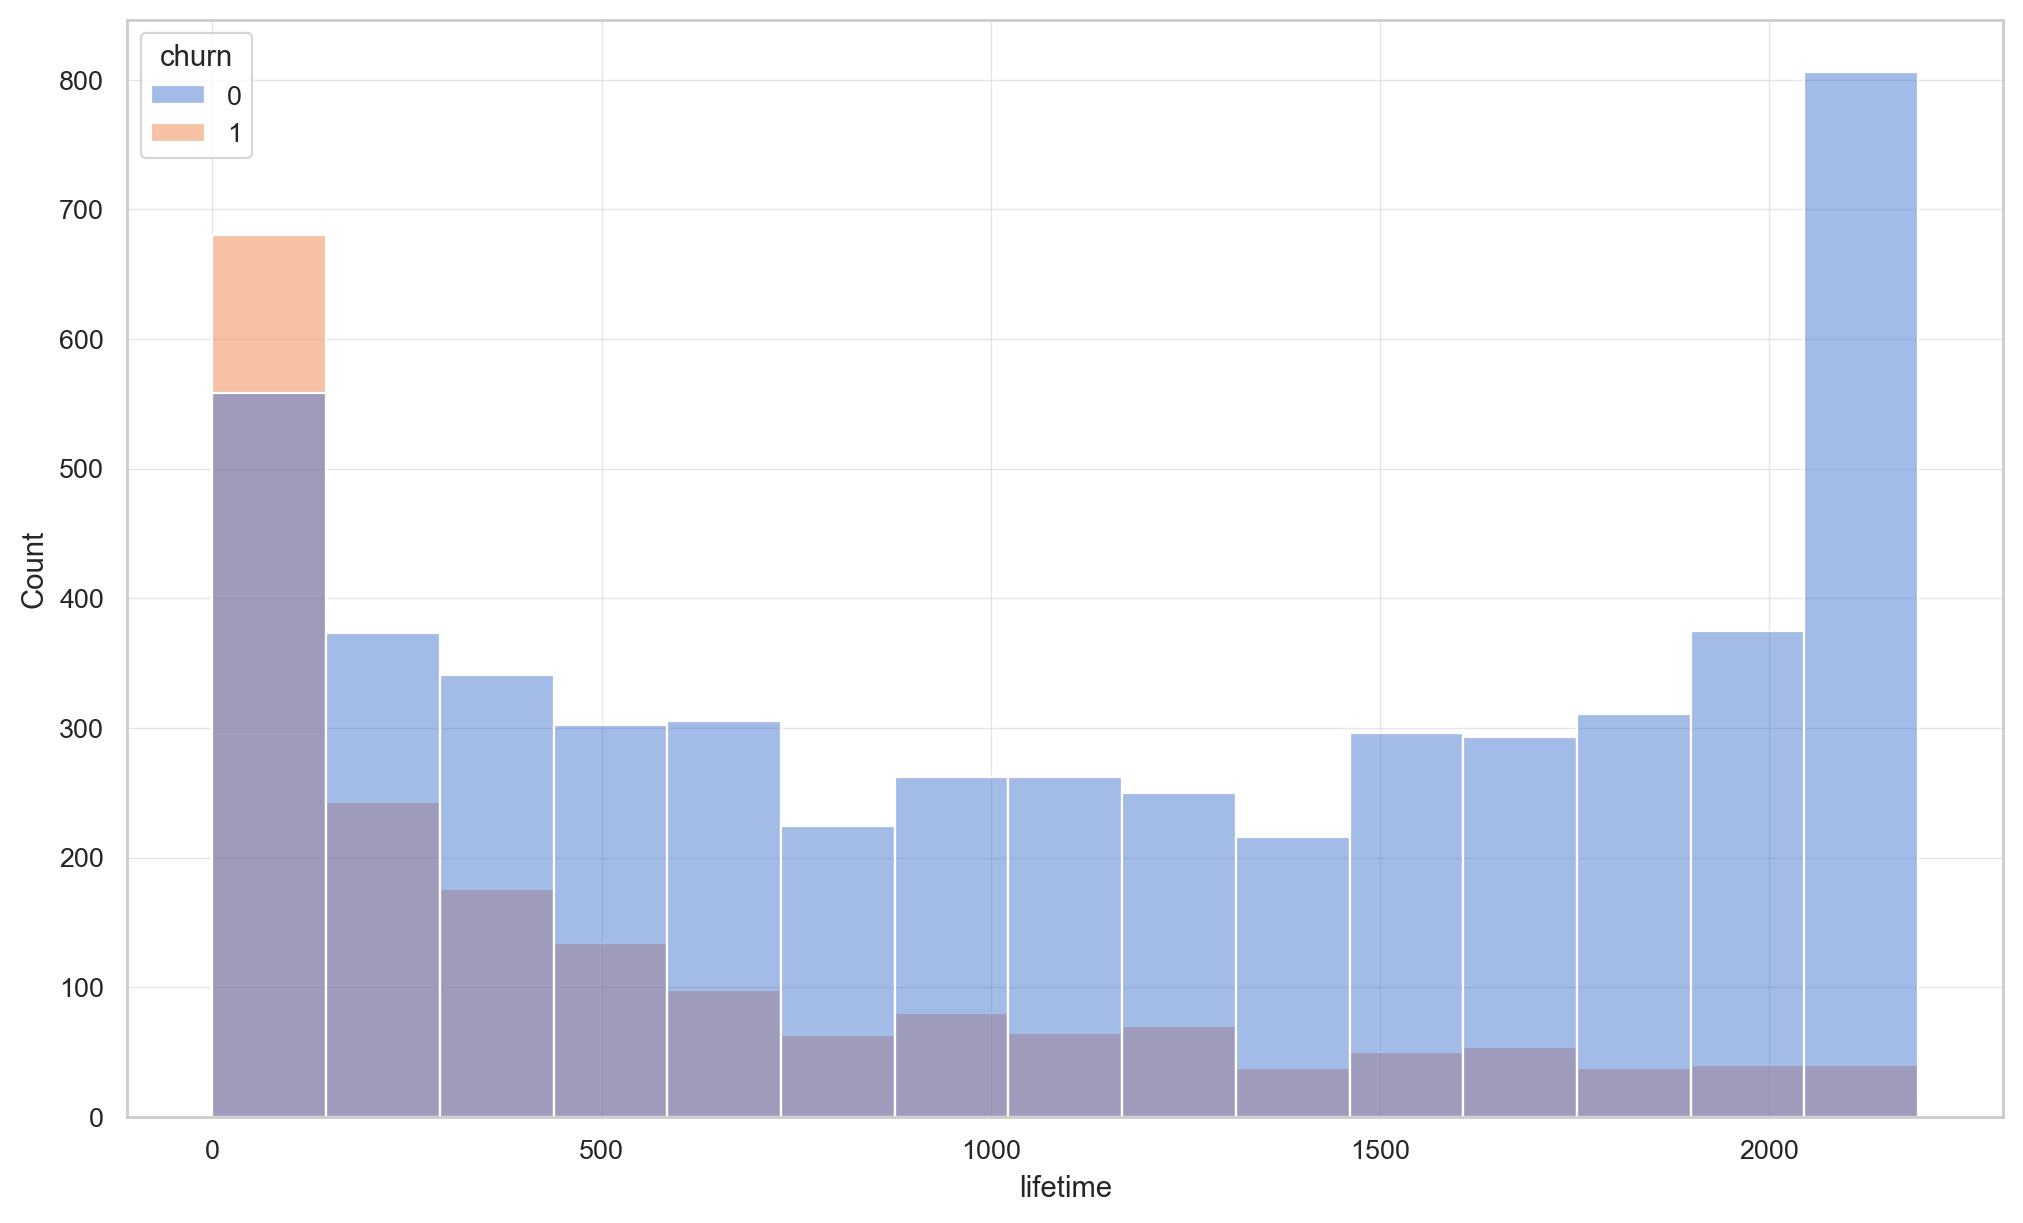

In [16]:
sns.histplot(data=df, x='lifetime', hue='churn');

Определим какими услугами пользуются клиенты.

In [17]:
df['services_used'] = (~df.multiple_lines.isna()) *1 + (~df.internet_service.isna()) *10
df.services_used.replace({
    1: 'phone',
    10: 'internet',
    11: 'phone and internet'
}, inplace=True)

df.services_used.value_counts()

phone and internet    4835
phone                 1526
internet               682
Name: services_used, dtype: int64

Преобразуем total_charges в тип float.

In [18]:
def safe_cast(x):
    try:
        return float(x)
    except:
        return np.nan
    
df.total_charges = df.total_charges.map(safe_cast)

In [19]:
with pd.option_context('display.max_columns', None):
    display(
        df[df.total_charges.isna()]
    )
    
print('Количество пропусков после преобразования:',
      df.total_charges.isna().sum())

,customer_id,gender,senior_citizen,partner,dependents,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,churn,lifetime,services_used
488,4472-LVYGI,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,Yes,Bank transfer (automatic),52.550,NaN,NaN,DSL,Yes,No,Yes,Yes,Yes,No,0,0,internet
753,3115-CZMZD,Male,0,No,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.250,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,phone
936,5709-LVOEQ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,80.850,NaN,No,DSL,Yes,Yes,Yes,No,Yes,Yes,0,0,phone and internet
1082,4367-NUYAO,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.750,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,phone
1340,1371-DWPAZ,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Credit card (automatic),56.050,NaN,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No,0,0,internet
3331,7644-OMVMY,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,19.850,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,phone
3826,3213-VVOLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,25.350,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,phone
4380,2520-SGTTA,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,20.000,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,phone
5218,2923-ARZLG,Male,0,Yes,Yes,2020-02-01,2020-02-01,One year,Yes,Mailed check,19.700,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,phone
6670,4075-WKNIU,Female,0,Yes,Yes,2020-02-01,2020-02-01,Two year,No,Mailed check,73.350,NaN,Yes,DSL,No,Yes,Yes,Yes,Yes,No,0,0,phone and internet


Количество пропусков после преобразования: 11


total_charges не определен у новых клиентов с lifetime равным нулю.

> Следовательно заполним пропуски нулями.

In [20]:
df.total_charges.fillna(0, inplace=True)

Из гистограмм следует что пользователи одновременно использующие обе услуги имеют значительно более высокую CLV и месячные платежи.

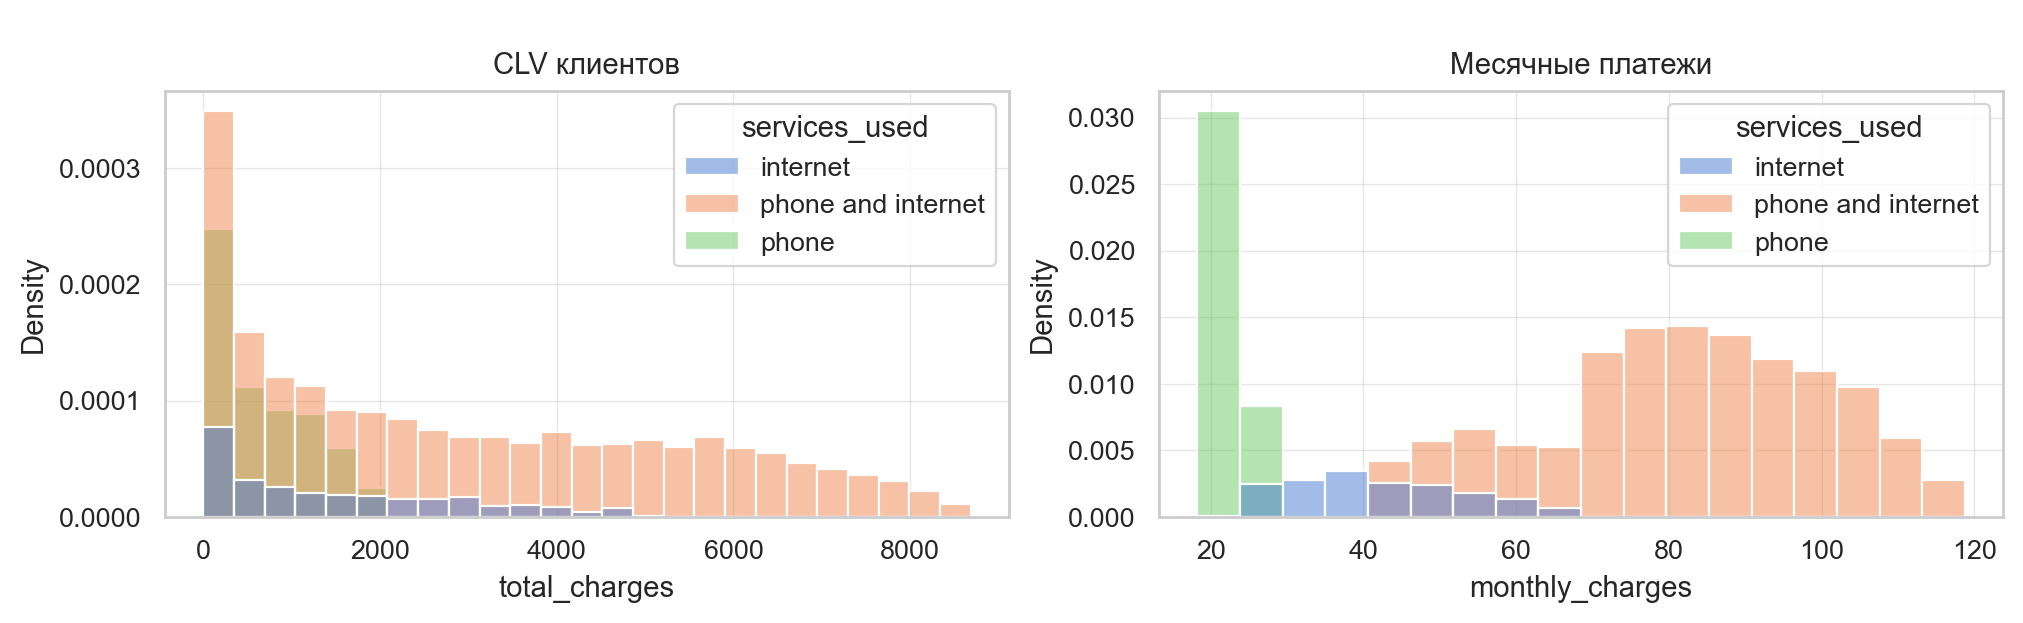

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.histplot(data=df, x='total_charges', hue='services_used', stat='density', ax=axes[0])
sns.histplot(data=df, x='monthly_charges', hue='services_used', stat='density', ax=axes[1])

axes[0].set_title('CLV клиентов')
axes[1].set_title('\nМесячные платежи')

plt.show()

Среди клиентов разорвавших договор обслуживания достаточно большой процент занимают клиенты с высоким месячным платежом.

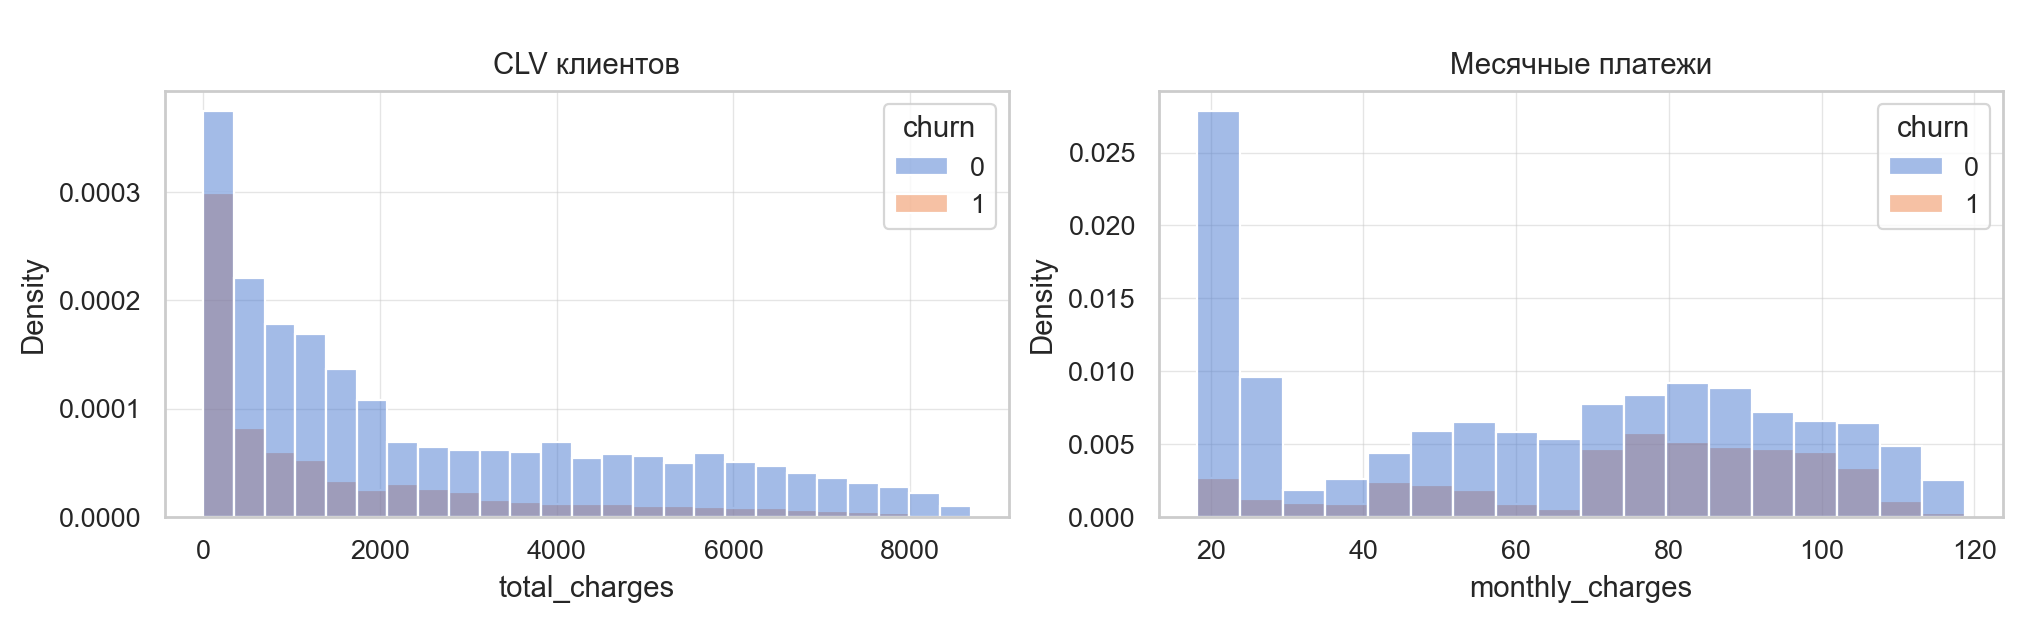

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(10,3))
sns.histplot(data=df, x='total_charges', hue='churn', stat='density', ax=axes[0])
sns.histplot(data=df, x='monthly_charges', hue='churn', stat='density', ax=axes[1])

axes[0].set_title('CLV клиентов')
axes[1].set_title('\nМесячные платежи')

plt.show()

Посмотрим краткий обзор данных в pandas_profiling.

In [23]:
profile = pandas_profiling.ProfileReport(df, title='Pandas Profiling Report', dark_mode=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Выводы

* Исправлены пропуски в данных.
* Добавлены новые признаки и выделена целевая переменная.
* У churn высокая Phik корреляция с датой начала пользования услуг и продолжительность. Но лучше взять lifetime отдельно от даты заключения контракта чтобы не было утечки данных.
* Признаки gender и streaming_movies следует убрать.

# Моделирование

Заполним оставшиеся пропуски 'No', что означает 'услуга не предоставлялась'.

In [24]:
df.fillna('No', inplace=True)
df.replace({'Yes': True,
            'No': False}, inplace=True)

cat_features=df.dtypes[(df.dtypes == object) | (df.dtypes == bool)].index.tolist()
df.loc[:, cat_features] = df[cat_features].astype('category')

Функция для обновления catboost pool с учетом дополненного drop list.

In [25]:
def upd_train_pool(X, y, drop_list):
    X = X[list(set(X.columns) - set(drop_list))]
    cat_features=X.dtypes[(X.dtypes == 'category')].index.tolist()
    return Pool(X, y, cat_features=cat_features)

Разделим выборку на train и test.

In [26]:
# Удалим лишние признаки. Так, gender не оказывает никакого влияния на другие признаки,
# а streaming_tv дублирует streaming_movies.
drop_list = ['customer_id', 'churn', 'begin_date', 'end_date', 'gender', 'streaming_tv']
X = df.drop(drop_list, axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size,
    random_state=random_state,
)

catboost_pool = upd_train_pool(X_train, y_train, drop_list)

print(X_train.shape, X_test.shape)

(5634, 17) (1409, 17)


Воспользуемся randomized_search для поиска оптимальных гиперпараметров.

In [27]:
params={
    'loss_function': 'Logloss',
    'logging_level': 'Silent',
    'depth': 4,
    'random_seed': random_state,
    'eval_metric':'AUC:hints=skip_train~false',
}

model = CatBoost(params=params)

param_grid = {
    'subsample': np.linspace(0.7, 1, 11),
    'random_strength': np.linspace(0.7, 1, 11),
    'border_count': range(300, 500, 10),
    'learning_rate': [0.01, 0.1],
}

search = model.randomized_search(
    param_grid,
    catboost_pool,
    cv=5,
    n_iter=50,
    search_by_train_test_split=False,
    partition_random_seed=random_state,
    verbose=False,
)

params.update(search['params'])
search['params']

{'border_count': 360,
 'subsample': 0.91,
 'random_strength': 0.82,
 'learning_rate': 0.1}

Результат после подбора гиперпараметров.

In [28]:
y_hat = model.predict(X_test[list(set(X.columns) - set(drop_list))],
                      prediction_type='Class')
y_prod = [x[1] for x in model.predict(X_test[list(set(X.columns) - set(drop_list))],
                                      prediction_type='Probability')]
print('Classification Report'.center(54, '-'))
print(classification_report(y_test, y_hat))
print(f'ROC AUC: {roc_auc_score(y_test, y_prod):.3f}')

----------------Classification Report-----------------
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1015
           1       0.86      0.71      0.78       394

    accuracy                           0.89      1409
   macro avg       0.88      0.83      0.85      1409
weighted avg       0.88      0.89      0.88      1409

ROC AUC: 0.937


Из feature_importance видно, что не все признаки одинаково полезны, попробуем последовательно их убирать, обновляя и сравнивая метрику.

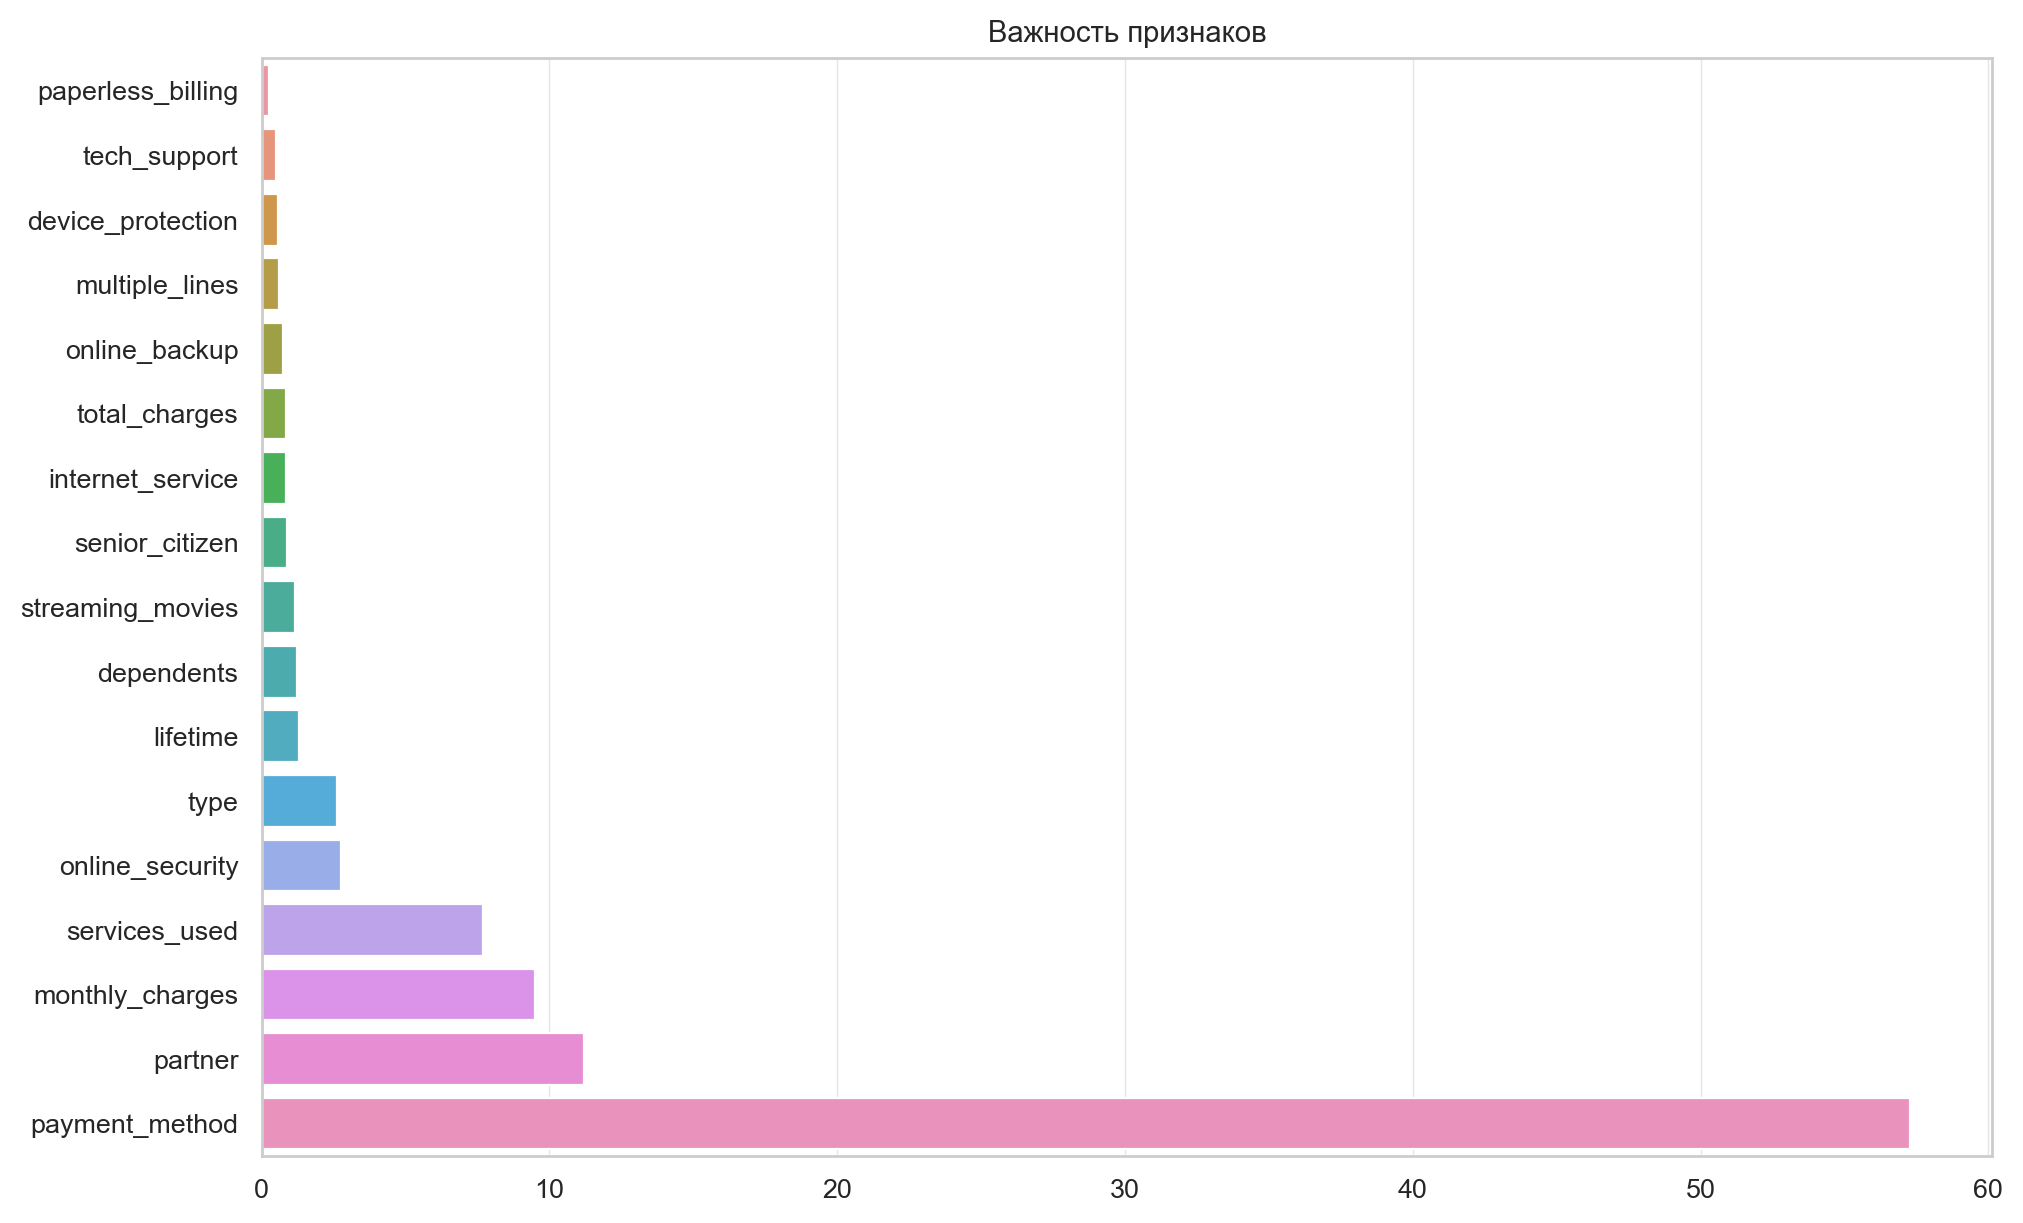

In [29]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
columns = list(np.array(X_train.columns)[sorted_idx])

sns.barplot(y=columns,
            x=feature_importance[sorted_idx])

plt.title('Важность признаков')
plt.show()

Отбросим признаки которые ухудшают метрику на тренировочной выборке.

In [30]:
# Первый расчет будет проведен для всех признаков.
roc_auc = 0
columns.insert(0, 'none')

for c in columns:
    # Кросс-валидация при удаленном признаке 'с'.
    cv_result = cv(upd_train_pool(X_train, y_train,
                                  drop_list + [c]),
                   params,
                   stratified=True,
                   fold_count=3,
                   seed=random_state,
                   partition_random_seed=random_state)
    
    # Если на CV метрика при удалении признака улучшилась, то добавляем её в drop_list.
    roc_auc_c = cv_result.loc[999,'test-AUC-mean']
    if roc_auc_c >= roc_auc:
        roc_auc = roc_auc_c
        drop_list.append(c)
        
print(drop_list)

['customer_id', 'churn', 'begin_date', 'end_date', 'gender', 'streaming_tv', 'none', 'paperless_billing', 'multiple_lines', 'total_charges', 'online_security', 'monthly_charges', 'partner', 'payment_method']


В drop_list попали даже total_charges и monthly_charges. Любопытно как это скажется на результатах.

> Отметим, что соотношение total_charges / monthly_charges примерно равно lifetime.

In [31]:
catboost_pool = upd_train_pool(X_train, y_train, drop_list)
model.fit(catboost_pool)

# Подберем оптимальную threshold.
roc_curve_values = get_roc_curve(model, catboost_pool)
boundary = select_threshold(model, curve=roc_curve_values)

# Посчитаем y_prod для ROC AUC и y_hat для обновленного Classification Report.
y_prod = [x[1] for x in model.predict(X_test[list(set(X.columns) - set(drop_list))],
                                      prediction_type='Probability')]
y_hat = [x[1] > boundary for x in model.predict(X_test[list(set(X.columns) - set(drop_list))],
                                                prediction_type='Probability')]

print('Updated Classification Report'.center(54, '-'))
print(classification_report(y_test, y_hat))
print(f'Граница: {boundary:.3f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_prod):.3f}')

------------Updated Classification Report-------------
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      1015
           1       0.76      0.90      0.82       394

    accuracy                           0.89      1409
   macro avg       0.86      0.89      0.87      1409
weighted avg       0.90      0.89      0.89      1409

Граница: 0.269
ROC AUC: 0.960


Оценим значимость признаков воспользовавшись библиотекой shap.

In [32]:
X_test = X_test[list(set(X.columns) - set(drop_list))]

explainer = shap.Explainer(model)
shap_values = explainer(X_test)

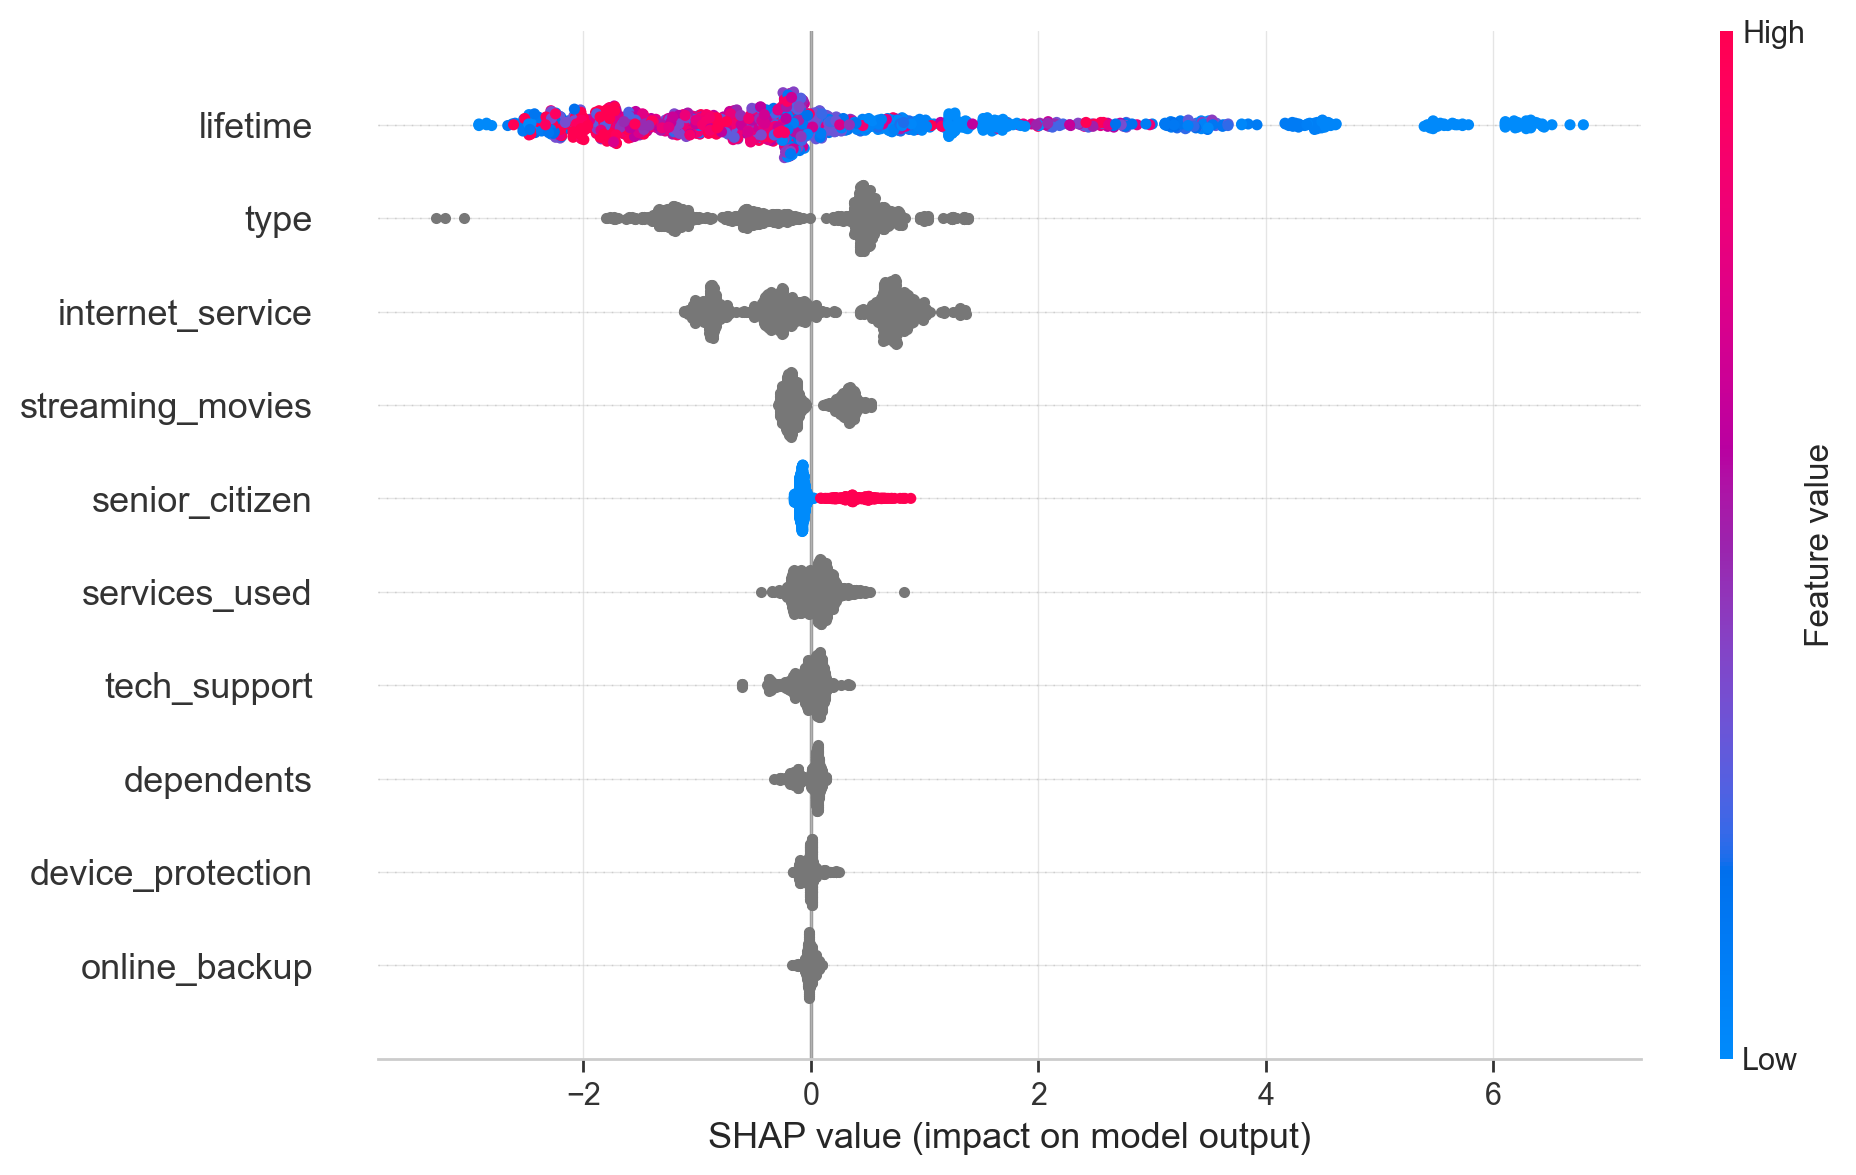

In [33]:
fig = plt.figure(constrained_layout=False)
shap.summary_plot(shap_values, X_test, plot_size=[10,6])
plt.show()

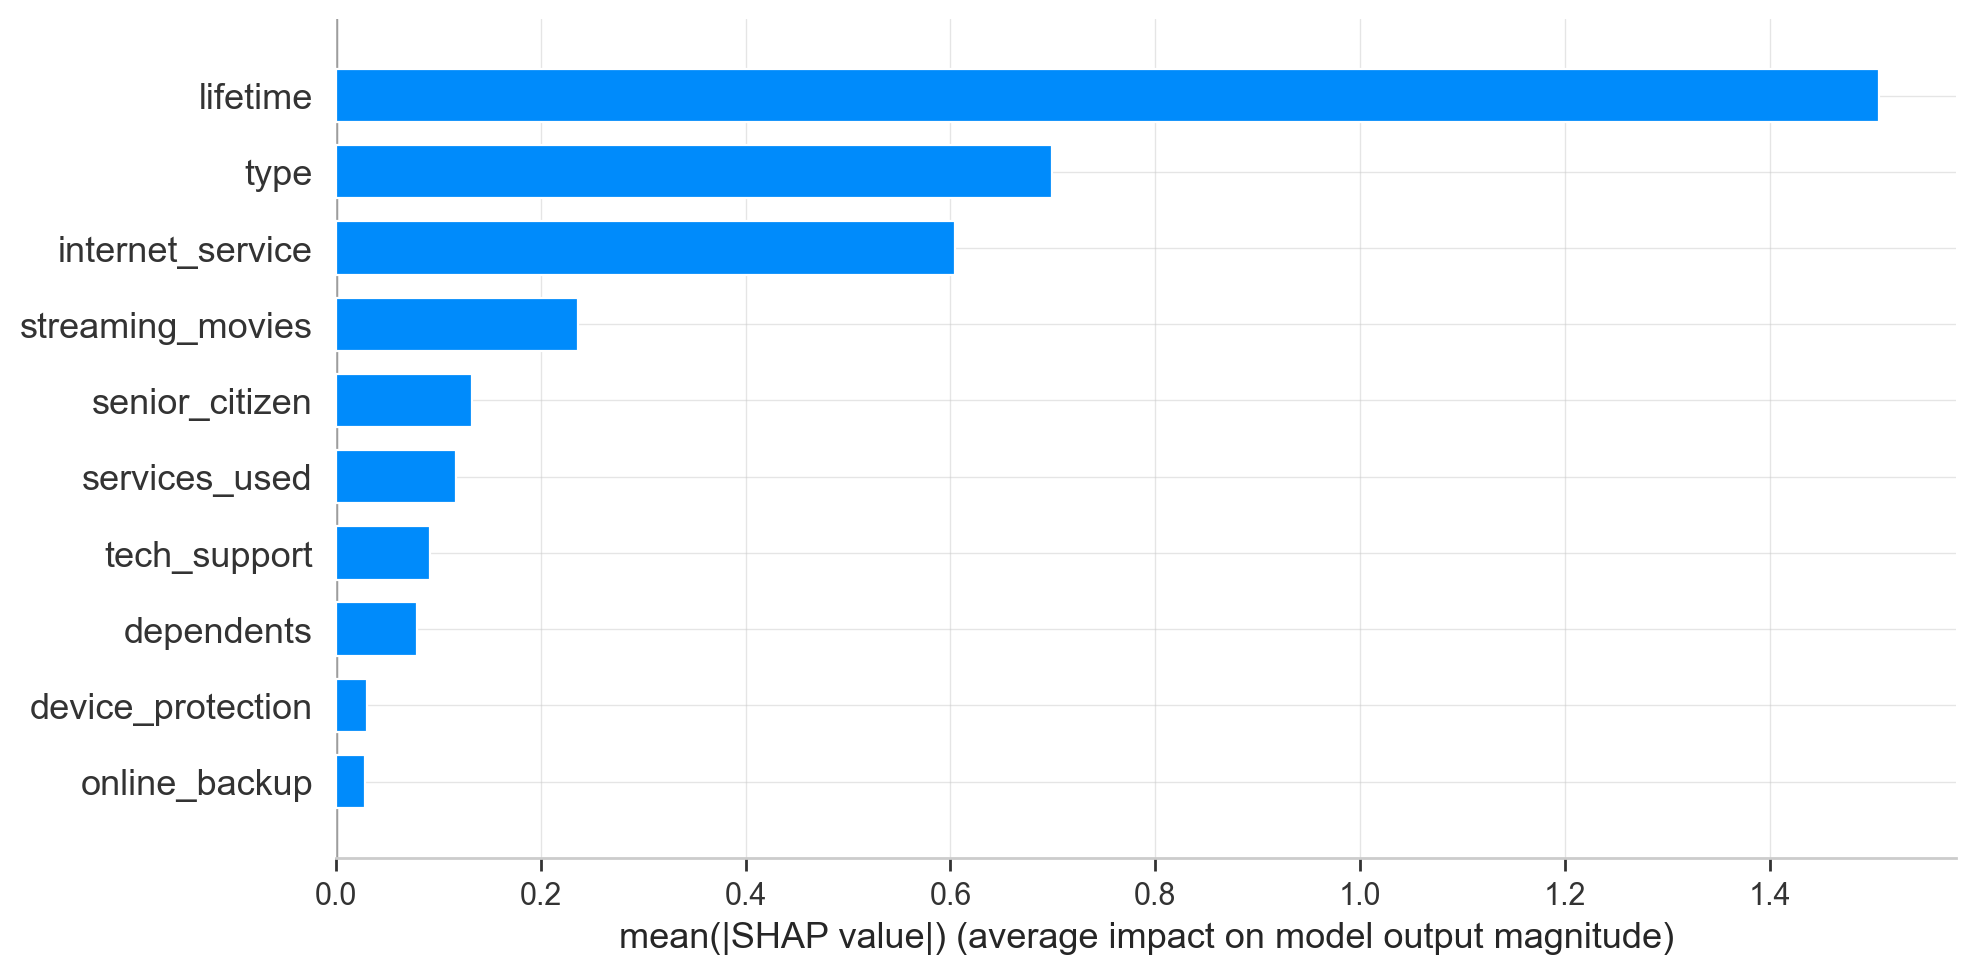

In [34]:
fig = plt.figure(constrained_layout=False)
shap.summary_plot(shap_values, X_test, plot_size=[10,6],
                  plot_type='bar')
plt.show()

# Вывод

* Проведено моделирование на модели CatBoost. Подобраны гиперпараметры.
    * Выбрана оптимальная граница, при которой достигается повышенная полнота (recall).
* Метрика ROC AUC составила 0.960 с параметрами subsample=0.91, depth=4, learning_rate=0.1 и border_count=360 при random_strength=0.82.
* Выделены наиболее значимые признаки. Определяющий вклад вносит сумарное количество дней, которые клиент пользуется услугами компании, наличие интернет-подключения и тип контракта.
    * Так, следует больше внимания уделять новым клиента, которые только подключились.
    * Целесообразно мягко переводить абонентов на internet услуги, это повышает их лояльность компании.
* Из графика ежемесячных платежей видно, что отток больше у клиентов с высокой ежемесячной платой, возможно клиенты не в состоянии самостоятельно подобрать подходящий им по стоимости пакет услуг и уходят.